<a href="https://colab.research.google.com/github/katarinagresova/ia161/blob/main/Opinion_mining_Sentiment_analysis/IA161_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

Inspired by [Word Vectors from PMI Matrix](https://www.kaggle.com/gabrielaltay/word-vectors-from-pmi-matrix) and [Sentiment Analysis (Text Mining)](https://www.kaggle.com/rosado/sentiment-analysis-text-mining).

The aim of this notebook is to demonstrate sentiment analysis, particularly on new words from the crowd-sourced website http://cestina20.cz. We scraped the data from Cestina 2.0 into a [CSV file](http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20.csv) that is part of this project.

First, we try to recognize the sentiment of dictionary entries using the [Liu's Opinion Lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon). For Czech, we automatically translated the entries using Google Translate and files are part of this project: [positive-words-cs.txt](http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/positive-words-cs.txt) and [negative-words-cs.txt](http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/negative-words-cs.txt).


# Setup

## Get the data

Download the data using `wget`.

In [1]:
!wget http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20.csv
!wget http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/positive-words-cs.txt
!wget http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/negative-words-cs.txt

--2021-11-20 16:08:00--  http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20.csv
Resolving nlp.fi.muni.cz (nlp.fi.muni.cz)... 147.251.51.11
Connecting to nlp.fi.muni.cz (nlp.fi.muni.cz)|147.251.51.11|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20.csv [following]
--2021-11-20 16:08:00--  https://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20.csv
Connecting to nlp.fi.muni.cz (nlp.fi.muni.cz)|147.251.51.11|:443... connected.
HTTP request sent, awaiting response... 200 Ok
Length: 828572 (809K) [text/csv]
Saving to: ‘cestina20.csv’

cestina20.csv       100%[===================>] 809.15K  1.30MB/s    in 0.6s    

2021-11-20 16:08:02 (1.30 MB/s) - ‘cestina20.csv’ saved [828572/828572]

--2021-11-20 16:08:02--  http://nlp.fi.muni.cz/trac/researc

## Tools
### Tokenizer
We use NLTK standard tokenizer to split the texts by words. Splitting by spaces is not enough, since we want e.g. "word" and "word," to be one token. Tokenization is not strongly language dependent, so NLTK standard tokenizer is enough. If we want to process languages that do not use spaces (CJK, or Chinese, Japanese, Korean), we should modify this part.

### Stopwords
For training the word vectors, we use stoplists of Czech most common words. This helps especially in cases we have small data (our case).

In [2]:
!wget https://raw.githubusercontent.com/stopwords-iso/stopwords-cs/master/stopwords-cs.txt

--2021-11-20 16:08:49--  https://raw.githubusercontent.com/stopwords-iso/stopwords-cs/master/stopwords-cs.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2404 (2.3K) [text/plain]
Saving to: ‘stopwords-cs.txt’

stopwords-cs.txt    100%[===================>]   2.35K  --.-KB/s    in 0s      

2021-11-20 16:08:49 (26.5 MB/s) - ‘stopwords-cs.txt’ saved [2404/2404]



## Python packages
### Pandas
Pandas is a data science standard that allows easy work with large tabular data. Pandas DataFrame is the object we use in this project.

### SciKit Learn
SciKit Learn (`sklearn`) is a standard machine learning package for Python. We use its `cosine_similarity` function.

#### Numpy
Together with `sklearn` a Python machine learning standard. Provides straightforward matrix computation, so we avoid unhealthy nested for-cycles.

In [ ]:
# it depends on installation but probably this is not necessary
# in case it does not work, try pip instead of pip3
# DO NOT RUN in Colab, this is only useful if you download the notebook and use on your computer
!pip3 install --user nltk
!pip3 install --user sklearn

In [3]:
from collections import Counter
import itertools

import os
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Settings

Code in this notebook is also prepared for working with english data from Urban dictionary.

In [4]:
LANG_SETTINGS = {"en": {"filename":"urban_dictionary.csv", "sep":",", "explanation":"definition"},
                 "cs": {"filename":"cestina20.csv", "sep":";", "explanation":"explanation"}
                }
selected_language = 'cs'
settings = LANG_SETTINGS[selected_language]

# Data
We prepared the data in advance using web crawling and parsing of the HTML pages. Look at a sample of the CSV.

In [5]:
df = pd.read_csv(settings['filename'], sep=settings['sep'], keep_default_na=False)
df.head()

,word,explanation,example,rating up,rating down,author,date
0,rathifikovat,odsouhlasit úplatek podle Davida Ratha - viz...,""" Ještě že mu ten úplatek nerathifikoval!""",2,0,metro,20. 2. 2016
1,ezomlha,motivační literatura plná klišé a banálních po...,,35,3,Svenski,19. 8. 2019
2,nadkundí,"podbřišek, část ženského těla nad přirozením",""" Bolí mě po tom zákroku celý nadkundí.""",21,5,Iveta Kokyová,29. 7. 2013
3,dadák,"rána pěstí, po které jde člověk k zemi (dadá)","""Tak mě nasral, že ode mě dostal dadáka.""”",21,6,Garry,17. 11. 2016
4,lajfka,nahrávka z živého vystoupení z angl. live (živě),,8,3,Česká filharmonie,6. 1. 2019


## Explanations
We try to recognize dictionary entry sentiment from the explanation. Let's see an example, next, let's convert the explanations into token sequences and remove stopwords.

In [6]:
df[settings['explanation']][1000]

'jeho hodnota určuje vaši společenskou důležitost  počítají se body za hodinky (zapomeňte na quartzky), oblečení (značkové), auto (prémiové), mobil (samozřejmě iPhone a jiný " in"  fón), partnerku (luxusní prsatá blondýna zvyšuje machr index apod.) atd., součet těchto bodů pak tvoří machr index'

In [7]:
explanations = df[settings['explanation']].tolist()
# remove stopwords
stopwords_set = ['-','.',':',';','"',',', '!', '(', ')', '``', "'", "''", "„", "”", "...", "apod", "viz", 'např', "například", "příklad"]
with open('stopwords-{}.txt'.format(selected_language), encoding='utf-8') as f:
    stopwords_set.extend(list(set([w.strip() for w in f.readlines()])))
#print(stopwords_set)
explanations = [
    [tok.lower() for tok in word_tokenize(explanation.replace('&#8230;', '...').replace('&#8230', '...')) if tok.lower() not in stopwords_set] for explanation in explanations
]
# show results
explanations[1000]

['hodnota',
 'určuje',
 'společenskou',
 'důležitost',
 'počítají',
 'body',
 'hodinky',
 'zapomeňte',
 'quartzky',
 'oblečení',
 'značkové',
 'auto',
 'prémiové',
 'mobil',
 'samozřejmě',
 'iphone',
 'jiný',
 'in',
 'fón',
 'partnerku',
 'luxusní',
 'prsatá',
 'blondýna',
 'zvyšuje',
 'machr',
 'index',
 'atd.',
 'součet',
 'těchto',
 'bodů',
 'tvoří',
 'machr',
 'index']

# Recognize sentiment using the Opinion Lexicon

**TASK 1**: Look in the original opinion lexicon, look in the translated version. Comment on what you see in both resources.

The easiest way is to go through all tokens in the explanation and sum their sentiment according to the Opinion Lexicon. Since some opinion lexicons distinguish *strong* and *weak* opinions we convert the input data into positive or negative numbers in a similar way, except we do not distinguish the intensity of the sentiment, only the polarity: -2 for negative words, 2 for positive words, 0 for words present in both files.

**SOLUTION 1**: Since words are translated using google translator, there is no check if sentiment is preserved. I found several examples that don't really make sence:
 - asunder -> podle
 - aweful -> úžasné (in negative-words)

Also, when there probably was no translation, there is english word in czech lexicon.
 - achey -> achey

And czech lexicon also contains the same words several times.

In [8]:
with open('positive-words-{}.txt'.format(selected_language),'rb') as f:
    positive_words = [w.strip().lower() for w in f.read().decode('utf-8','ignore').split('\n')]
with open('negative-words-{}.txt'.format(selected_language),'rb') as f:
    negative_words = [w.strip().lower() for w in f.read().decode('utf-8','ignore').split('\n')]
"No. of positive words:", len(positive_words), "No. of negative words:", len(negative_words)

('No. of positive words:', 2007, 'No. of negative words:', 4601)

In [9]:
 # we put a small epsilon in order to distinguish sentences with no recognized sentiment from sentences with positive+negative sentiment
score_word_dict = {k:2.00001 for k in positive_words}
score_word_dict.update({k:0 for k in negative_words if k in positive_words})
score_word_dict.update({k:-2 for k in negative_words if k not in positive_words})

In [10]:
def get_sentiment_sequence(tokens, score_word_dict):
    sentiment = 0
    for token in tokens:
        sentiment += score_word_dict.get(token, 0)
    return sentiment
df[settings['explanation']][1], get_sentiment_sequence(explanations[1], score_word_dict)

('motivační literatura plná klišé a banálních pouček', -2)

Calculate sentiment for all explanations and a column to the DataFrame.

In [11]:
scores=[]
for d in explanations:
    score = get_sentiment_sequence(d, score_word_dict)
    scores.append(score)
df['feeling_score_lexicon'] = scores
df.head()

,word,explanation,example,rating up,rating down,author,date,feeling_score_lexicon
0,rathifikovat,odsouhlasit úplatek podle Davida Ratha - viz...,""" Ještě že mu ten úplatek nerathifikoval!""",2,0,metro,20. 2. 2016,0.0
1,ezomlha,motivační literatura plná klišé a banálních po...,,35,3,Svenski,19. 8. 2019,-2.0
2,nadkundí,"podbřišek, část ženského těla nad přirozením",""" Bolí mě po tom zákroku celý nadkundí.""",21,5,Iveta Kokyová,29. 7. 2013,0.0
3,dadák,"rána pěstí, po které jde člověk k zemi (dadá)","""Tak mě nasral, že ode mě dostal dadáka.""”",21,6,Garry,17. 11. 2016,-2.0
4,lajfka,nahrávka z živého vystoupení z angl. live (živě),,8,3,Česká filharmonie,6. 1. 2019,-2.0


In [12]:
df.sort_values(by=['feeling_score_lexicon'], ascending=False).head()

,word,explanation,example,rating up,rating down,author,date,feeling_score_lexicon
3017,gloryhantr,"ten, co vždy podporuje ten sportovní tým, kter...","„Karel je typickej gloryhantr, už zase změnil ...",3,5,Krysa,14. 7. 2019,10.00005
1796,lajkolap,"chytlavý, zajímavý příspěvek na sociálních sít...","A: "" Dala jsem teď na fejsáč nějaký video s m...",2,1,mato,13. 11. 2015,8.00004
2870,fičák,"1. silný, výjimečný zážitek ("" Koncert Floydů ...",,5,2,,,8.00004
403,kafíčkování,"náplň práce mnoha manažerů, zejména těch marke...",""" Kafíčkování mi pomohlo k mnoha fajn kontaktů...",10,1,,,8.00004
333,wowovat,pořád dokola vyjadřovat obdiv či údiv anglický...,""" Ona v jednom kuse wowuje, už mi leze na nerv...",10,6,Prokeš,18. 6. 2011,8.00004


**TASK 2**: Add statistics about the dataset. How many dictionary entries have explanation? How many explanations have sentiment recognized?


In [13]:
def print_df_statistics(df, score_column):
  print("Number of rows: ", len(df))
  print("Number of explanations: ", (df.explanation != '').sum())
  print("Number of sentiments recognized: ", (df[score_column] != 0).sum())

In [14]:
print_df_statistics(df, 'feeling_score_lexicon')

Number of rows:  4275
Number of explanations:  4275
Number of sentiments recognized:  1387


# Word Vectors
The main problems of the naive solution are:
* small recall because of rather low quality of the lexicon (due to the automatic translation),
* small recall due to only one form of the word present in the lexicon. However, in Czech language, many different forms for a word exist, e.g. tlustý, tlustým, tlustých, tlustá, tlustého, tlustou.
* no context awareness of the method
 
    
We try to improve the sentiment recognition using word vectors. The main idea is the *distributional semantics* - an observation that similar words appear in similar contexts. There are many methods how to calculate word vectors, however, all of them take into account not only a token but also tokens in its surrounding (the context). Most techniques use a fixed window, in our case, the window is (-2, +2). For example, for the sentence "The quick brown fox jumped over the lazy dog.", using a sliding window we have the following sequences (stopword removal applied in the example):

\[quick, brown, fox, jumped, lazy\]<br>
\[brown, fox, jumped, lazy, dog\]

The distributional semantics assumes that *fox* is similar to other words that appear around the words *quick*, *brown*, *jumped*, *lazy*, *dog*.

### Token index
We convert the tokens in explanations (without stopwords) into an index. This is handy, since we will only calculate with numbers and provide the respective tokens via this token index only.

In [15]:
tok2indx = dict()
unigram_counts = Counter()
for ii, explanation in enumerate(explanations):
    for token in explanation:
        unigram_counts[token] += 1
        if token not in tok2indx:
            tok2indx[token] = len(tok2indx)
indx2tok = {indx:tok for tok,indx in tok2indx.items()}
print('done')
print('vocabulary size: {}'.format(len(unigram_counts)))
print('most common: {}'.format(unigram_counts.most_common(10)))

done
vocabulary size: 15748
most common: [('člověk', 337), ('1.', 235), ('2', 134), ('žena', 102), ('označení', 80), ('často', 76), ('2.', 65), ('muž', 64), ('velmi', 61), ('slang', 60)]


### Skipgrams
We calculate the frequencies of word tuples appearing in the same sliding window. You can see the most frequent tuples.

In [16]:
back_window = 2
front_window = 2
skipgram_counts = Counter()
for i, explanation in enumerate(explanations):
    for ifw, fw in enumerate(explanation):
        icw_min = max(0, ifw - back_window)
        icw_max = min(len(explanation) - 1, ifw + front_window)
        icws = [ii for ii in range(icw_min, icw_max + 1) if ii != ifw]
        for icw in icws:
            skipgram = (explanation[ifw], explanation[icw])
            skipgram_counts[skipgram] += 1    
        
print('done')
print('number of skipgrams: {}'.format(len(skipgram_counts)))
print('most common: {}'.format(skipgram_counts.most_common(10)))

done
number of skipgrams: 92109
most common: [(('andreje', 'babiše'), 31), (('babiše', 'andreje'), 31), (('sociálních', 'sítích'), 21), (('sítích', 'sociálních'), 21), (('evropské', 'unie'), 18), (('unie', 'evropské'), 18), (('žena', 'dívka'), 14), (('dívka', 'žena'), 14), (('1.', 'člověk'), 14), (('člověk', '1.'), 14)]


## Token matrix
We store the skipgram frequencies in a (symmetric) matrix.


In [17]:
row_indxs = []
col_indxs = []
dat_values = []
ii = 0
for (tok1, tok2), sg_count in skipgram_counts.items():
    ii += 1
    if ii % 1000000 == 0:
        print(f'finished {ii/len(skipgram_counts):.2%} of skipgrams')
    tok1_indx = tok2indx[tok1]
    tok2_indx = tok2indx[tok2]
        
    row_indxs.append(tok1_indx)
    col_indxs.append(tok2_indx)
    dat_values.append(sg_count)
    
wwcnt_mat = sparse.csr_matrix((dat_values, (row_indxs, col_indxs)))
print(wwcnt_mat.shape)

(15748, 15748)


## Token similarity
In the token matrix, each row correspond to a token, the row is the word vector. The numbers in tha matrix show how often the token appears together with other tokens.
The following method calculates token similarity as a cosine of the angle between two word vectors.

In [18]:
def ww_sim(token, matrix, topn=10):
    """Calculate topn most similar words to word"""
    if token not in tok2indx:
        return 0
    indx = tok2indx[token]
    if isinstance(matrix, sparse.csr_matrix):
        v1 = matrix.getrow(indx)
    else:
        v1 = matrix[indx:indx+1, :]
    sims = cosine_similarity(matrix, v1).flatten()
    sindxs = np.argsort(-sims)
    sim_word_scores = [(indx2tok[sindx], sims[sindx]) for sindx in sindxs[0:topn]]
    return sim_word_scores

In [19]:
import pprint
if selected_language == "cs":
    pprint.pprint(ww_sim('obézní', wwcnt_mat))
    pprint.pprint(ww_sim('hezká', wwcnt_mat))
else:
    pprint.pprint(ww_sim('ugly', wwcnt_mat))
    pprint.pprint(ww_sim('girl', wwcnt_mat))

[('obézní', 0.9999999999999996),
 ('tučný', 0.6000000000000001),
 ('potí', 0.5773502691896257),
 ('zamračený', 0.5715476066494081),
 ('tlusťoch', 0.5715476066494081),
 ('nápadu', 0.5715476066494081),
 ('plešatý', 0.5422176684690383),
 ('moravském', 0.5196152422706631),
 ('tlustý', 0.5046751130152641),
 ('neduživý', 0.48989794855663554)]
[('hezká', 1.0),
 ('slečna', 0.6135719910778963),
 ('ošklivá', 0.565685424949238),
 ('malými', 0.4472135954999579),
 ('křehká', 0.4472135954999579),
 ('náctnice', 0.4472135954999579),
 ('žena', 0.4422676529195312),
 ('holka', 0.3985266984930429),
 ('pohledná', 0.3721042037676254),
 ('ugly', 0.3651483716701108)]


## Calculate sentiment for OOVs
Out-of-vocabulary terms is one of the problems in our first try. Let's try to expand the Opinion Lexicon by similar words. You can see that we now know the sentiment of words *not* present in the Opinion Lexicon.

In [20]:
def get_sentiment(token, score_word_dict, ww_matrix):
#    if token in score_word_dict.keys(): # alternative: calculate from vectors iff the word is not in the lexicon
#        return score_word_dict[token]
    sentiment = score_word_dict.get(token, 0)
    k = ww_sim(token, ww_matrix)
    if not k:
        return 0
    for sim, score in k:
        sentiment += score * score_word_dict.get(sim, 0)
    return sentiment
if selected_language=="cs":
    print('andrej', get_sentiment('andrej', score_word_dict, wwcnt_mat), score_word_dict.get('andrej'))
else:
    print('donald', get_sentiment('donald', score_word_dict, wwcnt_mat), score_word_dict.get('donald'))

andrej -0.7559289460184544 None


In [21]:
def get_sentiment_sequence(tokens, score_word_dict, ww_matrix):
    sentiment = 0
    for token in tokens:
        sentiment += get_sentiment(token, score_word_dict, ww_matrix)
    return sentiment
df[settings['explanation']][1], get_sentiment_sequence(explanations[1], score_word_dict, wwcnt_mat)

('motivační literatura plná klišé a banálních pouček', -5.546319477921561)

In [22]:
# This operation takes time. It calculates sentiment for each word in all explanations from the matrix. It could be optimized e.g. by not calculating the same word multiple times.
# We calculate the time spent using the time magic.
def calculate_scores(explanations, score_word_dict, wwcnt_mat):
    scores=[]
    for d in explanations:
        score = get_sentiment_sequence(d, score_word_dict, wwcnt_mat)
        scores.append(score)
    return scores
%time scores = calculate_scores(explanations, score_word_dict, wwcnt_mat)
df['feeling_score_wv'] = scores
df.head()

CPU times: user 1min 38s, sys: 1.86 s, total: 1min 40s
Wall time: 1min 39s


,word,explanation,example,rating up,rating down,author,date,feeling_score_lexicon,feeling_score_wv
0,rathifikovat,odsouhlasit úplatek podle Davida Ratha - viz...,""" Ještě že mu ten úplatek nerathifikoval!""",2,0,metro,20. 2. 2016,0.0,-0.816497
1,ezomlha,motivační literatura plná klišé a banálních po...,,35,3,Svenski,19. 8. 2019,-2.0,-5.546319
2,nadkundí,"podbřišek, část ženského těla nad přirozením",""" Bolí mě po tom zákroku celý nadkundí.""",21,5,Iveta Kokyová,29. 7. 2013,0.0,0.000000
3,dadák,"rána pěstí, po které jde člověk k zemi (dadá)","""Tak mě nasral, že ode mě dostal dadáka.""”",21,6,Garry,17. 11. 2016,-2.0,-8.404604
4,lajfka,nahrávka z živého vystoupení z angl. live (živě),,8,3,Česká filharmonie,6. 1. 2019,-2.0,-6.613606


In [23]:
df.sort_values(by=['feeling_score_wv']).head()

,word,explanation,example,rating up,rating down,author,date,feeling_score_lexicon,feeling_score_wv
2649,hejt,"vyjádření nenávisti, odporu k něčemu z anglic...",""" Mám tady další hejt, kterej mě točí.""",31,8,Achjo Bitch,9. 11. 2011,-10.0,-37.341317
2901,panenská fáma,"velmi rozšířený blud o tom, že roztržení panen...","A: „Strašně se bojím, že mě bude bolet protrž...",14,7,Rošťanda Lenka,10. 8. 2018,-8.0,-34.434592
3185,odkráglovat,"1. zabít, připravit někoho o život z něm. abk...",„Ministra odkrágloval nájemný vrah.”2. unavit ...,12,0,Radek Simkanič,7. 3. 2019,-8.0,-31.839401
3872,maglajz,1. magnesium používané horolezci při lezení na...,""" Máš v tom pytlíku ještě nějaký maglajz?"" 2. ...",35,0,mato,28. 10. 2014,-8.0,-31.244627
2587,technostres,"nutkavá potřeba být neustále on-line, na příjm...",,13,4,iDnes,22. 5. 2017,-8.0,-30.244286


**TASK 3**: Calculate the same statistics as for Result 1. How did word vectors improve the number of recognized words in the explanations?

In [24]:
print_df_statistics(df, 'feeling_score_wv')

Number of rows:  4275
Number of explanations:  4275
Number of sentiments recognized:  3283


# Evaluation
For this course, we manually annotated sentiment for 400 Czech explanations. We will compare the sentiment recognized by our methods with the manual annotation.

In [25]:
!wget http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20_annotation.csv

--2021-11-20 16:30:51--  http://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20_annotation.csv
Resolving nlp.fi.muni.cz (nlp.fi.muni.cz)... 147.251.51.11
Connecting to nlp.fi.muni.cz (nlp.fi.muni.cz)|147.251.51.11|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20_annotation.csv [following]
--2021-11-20 16:30:51--  https://nlp.fi.muni.cz/trac/research/raw-attachment/wiki/private/AdvancedNlpCourse/OpinionSentiment/cestina20_annotation.csv
Connecting to nlp.fi.muni.cz (nlp.fi.muni.cz)|147.251.51.11|:443... connected.
HTTP request sent, awaiting response... 200 Ok
Length: 37121 (36K) [text/csv]
Saving to: ‘cestina20_annotation.csv’

cestina20_annotatio 100%[===================>]  36.25K  --.-KB/s    in 0.1s    

2021-11-20 16:30:53 (297 KB/s) - ‘cestina20_annotation.csv’ saved [37121/37121]



In [26]:
annotation = None
if selected_language=="cs":
    dfa = pd.read_csv('cestina20_annotation.csv', sep=';')
    annotation = pd.merge(df, dfa, on='word') #df.loc[:len(dfa)-1,]
else:
    print("no ground truth (manual annotations) available")

In [27]:
annotation.head()

,word,explanation_x,example,rating up,rating down,author,date,feeling_score_lexicon,feeling_score_wv,explanation_y,annotation
0,rathifikovat,odsouhlasit úplatek podle Davida Ratha - viz...,""" Ještě že mu ten úplatek nerathifikoval!""",2,0,metro,20. 2. 2016,0.0,-0.816497,odsouhlasit úplatek podle Davida Ratha - viz...,-1
1,ezomlha,motivační literatura plná klišé a banálních po...,,35,3,Svenski,19. 8. 2019,-2.0,-5.546319,motivační literatura plná klišé a banálních po...,-1
2,nadkundí,"podbřišek, část ženského těla nad přirozením",""" Bolí mě po tom zákroku celý nadkundí.""",21,5,Iveta Kokyová,29. 7. 2013,0.0,0.000000,"podbřišek, část ženského těla nad přirozením",-1
3,dadák,"rána pěstí, po které jde člověk k zemi (dadá)","""Tak mě nasral, že ode mě dostal dadáka.""”",21,6,Garry,17. 11. 2016,-2.0,-8.404604,"rána pěstí, po které jde člověk k zemi (dadá)",-1
4,lajfka,nahrávka z živého vystoupení z angl. live (živě),,8,3,Česká filharmonie,6. 1. 2019,-2.0,-6.613606,nahrávka z živého vystoupení z angl. live (živě),0


**TASK 4 (cs)**: Insert code to calculate confusion matrix for both `feeling_score_lexicon` and `feeling_score_wv` with `annotation`. Assume that the opinion recognition is correct if the score == 0 or the same polarity. Which sentiment recognition is more accurate? Why?

## Opinion lexicon

In [28]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
df['annotation']=np.sign(df['feeling_score_lexicon'])
m = confusion_matrix(annotation['annotation'].values, df['annotation'].values[:len(annotation)])

In [29]:
c = precision_recall_fscore_support(annotation['annotation'].values, df['annotation'].values[:len(annotation)])
avg_f1 = np.mean(c[2])
c, avg_f1

((array([0.84705882, 0.54117647, 0.28813559]),
  array([0.39130435, 0.80701754, 0.38636364]),
  array([0.53531599, 0.64788732, 0.33009709]),
  array([184, 171,  44])),
 0.5044334654841381)

In [30]:
m


array([[ 72,  91,  21],
       [ 12, 138,  21],
       [  1,  26,  17]])

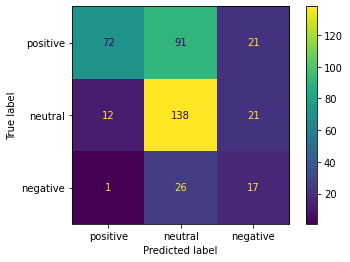

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=m,
                              display_labels=['positive', 'neutral', 'negative'])
disp.plot()

## Word vectors

In [32]:
df['annotation_wv']=np.sign(df['feeling_score_wv'])
m_wv = confusion_matrix(annotation['annotation'].values, df['annotation_wv'].values[:len(annotation)])

In [33]:
c_wv = precision_recall_fscore_support(annotation['annotation'].values, df['annotation_wv'].values[:len(annotation)])
avg_f1_wv = np.mean(c_wv[2])
c_wv, avg_f1_wv

((array([0.58050847, 0.59459459, 0.20224719]),
  array([0.74456522, 0.25730994, 0.40909091]),
  array([0.65238095, 0.35918367, 0.27067669]),
  array([184, 171,  44])),
 0.4274137725265545)

In [34]:
m_wv

array([[137,  20,  27],
       [ 83,  44,  44],
       [ 16,  10,  18]])

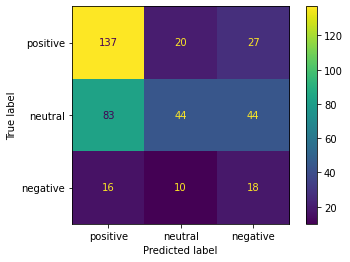

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=m_wv,
                              display_labels=['positive', 'neutral', 'negative'])
disp.plot()